In [1]:
%matplotlib inline

import pandas as pd
import watexr_forecast as wx
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')

# WATExR: Seasonal forecast workflow

## 1. Period of interest

Specify the year and season of interest in the cell below.

In [2]:
# Year of interest
year = 2001

# Season of interest. Choose from:
# ['winter', 'spring', 'early_summer', 'late_summer']
season = 'winter'

# Path to historic (EWEMBI) dataset for 1981 - 2010
ewembi_path = r'../../Data/Meteorological/01_ewembi_obs/ewembi_obs_1981-2010.dat'

# CSV to create summarising EWEMBI quantiles (optional - see Section 3)
quant_path = r'../../Data/Meteorological/01_ewembi_obs/ewembi_obs_quantiles_1981-2010.csv'

## 2. Get seasonal forecast 

Download and bias-correct (without cross-validation) the 15-member seasonal forecast for the specificed year and season.

**Note:** Takes several minutes to complete.

**Debugging:** If the call below fails, trying opening a terminal and running:

    cd projects/WATExR/Norway_Morsa/MetData_Processing/notebooks
    
then

    Rscript --vanilla get_seasonal_forecast.R 2001 5,6,7
    
This will give more informative errors.

In [3]:
%%time

# Download and bias correct S4 data
res = wx.get_seasonal_forecast(year, season)

The folder:
    WATExR/Norway_Morsa/Data/Meteorological/05_temporary_forecast_data/Morsa/CLIMATE

already contains S4 model output.



These files will be deleted and new data will be downloaded for the specified year and season.
Do you want to continue? (y/n):  y


Old data has been deleted.

Done.
Data saved to:
    WATExR/Norway_Morsa/Data/Meteorological/05_temporary_forecast_data

CPU times: user 11.2 ms, sys: 13.7 ms, total: 24.9 ms
Wall time: 3min 42s


## 3. (Re-)Calculate historic EWEMBI quantiles (optional)

**Note:** This cell only needs to be re-run if the EWEMBI dataset is changed or updated.

In [4]:
# Summarise EWEMBI data
wx.calculate_ewembi_quantiles(ewembi_path, 
                              quant_path, 
                              quants=[0.05, 0.33, 0.67, 0.95],
                              names=['date', 'time', 'uas', 'vas', 'ps', 'tas', 'pr', 'hurs', 'petH'],
                             )

## 4. Aggregate seasonal forecast data

In [5]:
# Average seasonal data
s4_df = wx.aggregate_seasonal_forecast(season, 
                                       par_list=['tas', 'pr', 'wind'],
                                       names=['date', 'time', 'uas', 'vas', 'ps', 'tas', 'pr', 'hurs', 'petH'],
                                      )
s4_df

,tas,pr,wind
member,,,
01,1.773439,5.554280,3.077508
02,0.409926,6.266166,3.354955
03,4.367437,6.135837,3.756871
04,-0.267474,4.591720,3.054421
05,1.729210,5.677443,3.211638
06,-0.447585,5.122389,2.998320
07,3.245002,7.223517,3.753462
08,2.478875,5.664315,3.087838
09,-0.121648,6.203819,3.226117


## 5. Compare S4 forecast to historic EWEMBI quantiles

Classifies the S4 forecast for this season as "Extreme low", "Below normal", " Near normal", "Above normal" or "Extreme high", based on historic EWEMBI quantiles.

In [6]:
# Classify forecast
res_dict = wx.compare_s4_to_ewembi(quant_path, 
                                   season, 
                                   s4_df, 
                                   par_list=['tas', 'pr', 'wind'],
                                   normal_quants=[0.33, 0.67], 
                                   extreme_quants=[0.05, 0.95],
                                  )

res_dict

{'tas': {'tercile': 'Above normal',
  'tercile_prob': 73.33333333333333,
  'extreme': 'Extreme high',
  'extreme_prob': 60.0},
 'pr': {'tercile': 'Above normal',
  'tercile_prob': 100.0,
  'extreme': 'Extreme high',
  'extreme_prob': 93.33333333333333},
 'wind': {'tercile': 'Near normal',
  'tercile_prob': 46.666666666666664,
  'extreme': 'Not extreme',
  'extreme_prob': 100.0}}

## 6. Make forecast PNG

**Note:** The forecast reliability score for "wind" is currently based on the ROCSS score for `uas` **only**. Need to fix this.

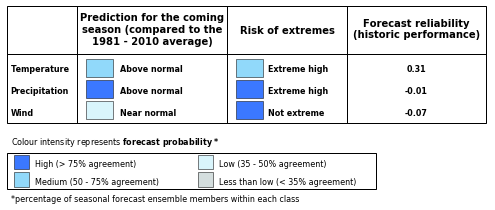

In [7]:
# Read table of historic performance
xl_path = r'../../Data/Meteorological/04_tercile_plots/seasonal_forecast_performance_1981-2010.xlsx'
perf_df = pd.read_excel(xl_path)

# Make summary image
forecast_png = r'forecast_output/climate_forecast_summary.png'
wx.make_climate_forecast_png(season, res_dict, perf_df, forecast_png)

## 7. Make forecast PDF

In [8]:
# Export PDF
wx.make_forecast_pdf(year, season)

Forecast saved to:

    /home/jovyan/projects/WATExR/Norway_Morsa/MetData_Processing/notebooks/forecast_output/morsa_forecast_winter_2001.pdf
